# Data Science Analyze and Present A/B Test Results






X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.

# A/B_TEST

## 1. Import libraries

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [40]:

def read_data():
    """
    Reads and loads control and test group data from CSV files.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the CSV file for the control group.
    """
    # Maximum Bidding (Existing)
    control = pd.read_csv("/content/sample_data/control_group.csv", sep=';')

    # Average Bidding (New)
    test = pd.read_csv("/content/sample_data/test_group.csv", sep=';')

    # Remove specific rows from control dataframe
    control.dropna(inplace=True)

    return control, test

def get_catvar(df):
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if df[col].dtype in ['object', 'bool']]
    cat_df = df[cat_col]
    return df, cat_df, cat_col

def get_numvar(cat_col, df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = df[num_col]
    return df, num_df, num_col

def fill_NaNValue(num_control):
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    imputer = KNNImputer(n_neighbors=8)
    num_control_imputed = pd.DataFrame(imputer.fit_transform(num_control), columns=num_control.columns)
    return num_control_imputed

def convert_datatype(control):
    """
    Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    int_columns = ['# of Impressions', 'Reach', '# of Website Clicks', '# of Searches',
                   '# of View Content', '# of Add to Cart', '# of Purchase']
    control[int_columns] = control[int_columns].astype('int64')
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    clf.fit_predict(test.iloc[:, 2:])

    test_scores = clf.negative_outlier_factor_
    print("Test Score: ", np.sort(test_scores)[:20])
    sns.boxplot(test_scores)
    plt.show()

    threshold = np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    print("Outlier indices:", test.loc[test_scores < -1.50].index)
    print("Threshold value:", test.loc[test_scores == threshold])

    # Modify extreme outlier
    test.iloc[0, 2:] = [2742.245945, 79574, 57168, 3086, 1263, 1098, 226, 277]

    # Plot boxplots for different variables
    for cols in [test.iloc[:, 3:5], test.iloc[:, 5:6], test.iloc[:, 6:]]:
        sns.boxplot(x="variable", y="value", data=pd.melt(cols))
        plt.show()

def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis.
    """
    for df in [control, test]:
        df["Website Click Through Rate"] = df["# of Website Clicks"] / df["# of Impressions"] * 100
        df["Number of Action"] = df.iloc[:, 2:8].sum(axis=1)
        df["Cost per Action"] = df["Spend [USD]"] / df["Number of Action"]
        df["Conversion Rate"] = df["Number of Action"] / df["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control, test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    columns = ["# of Purchase", "Website Click Through Rate", "Cost per Action", "Conversion Rate"]

    Group_A = control[columns].copy()
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = test[columns].copy()
    Group_B["Group"] = "B (AverageBidding)"

    AB = pd.concat([Group_A, Group_B])
    return AB, control["# of Purchase"], test["# of Purchase"]

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    return pd.concat([control_nop, test_nop], axis=1, keys=["A", "B"])

def num_boxplot(fig, axarr, dimensions, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in dimensions:
        for j in dimensions:
            if cols:
                c = cols.pop(0)
                sns.boxplot(y=c, x=hue, hue=hue, data=AB, ax=axarr[i][j])

def show_boxplot(nrows, ncols, dimensions, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, dimensions, cols, "Group")
    plt.tight_layout()
    plt.show()

def checkReject(p_value, alpha=0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha:
        print(f'{p_value} < alpha({alpha}) so >>> H0 REJECTED')
    else:
        print(f'{p_value} > alpha({alpha}) so >>> H0 CAN\'T BE REJECTED')

In [44]:
# Baseline conversion rate for retargeting campaigns for Regina Corporation
baseline_cr = 0.095
min_detectable_effect = 0.005
p2 = baseline_cr + min_detectable_effect
alpha = 0.05
beta = 0.2
alpha_zscore = -1.9599
beta_zscore = -0.8416

n = (((alpha_zscore * np.sqrt(2 * baseline_cr * (1 - baseline_cr))) + (beta_zscore * np.sqrt(baseline_cr * (1 - baseline_cr) + p2 * (1 - p2))))**2) / (abs(p2 - baseline_cr)**2)
print('Sample Size: ', round(n, 0))

Sample Size:  54359.0


## 3. Data Preparation

In [8]:
# TODO : Import the dataset available here : https://www.kaggle.com/code/dillonmyrick/a-b-test-hypothesis-testing-for-e-commerce/input
# https://www.kaggle.com/code/dillonmyrick/a-b-test-hypothesis-testing-for-e-commerce/input?select=control_group.csv

!kaggle datasets download -d a-b-test-hypothesis-testing-for-e-commerce/input?select=control_group.csv

403 - Forbidden - Permission 'datasets.get' was denied


In [21]:
from google.colab import files
import shutil

# Upload files
uploaded = files.upload()

# Move files to 'sample_data' folder
for filename in uploaded.keys():
    shutil.move(filename, f'/content/sample_data/{filename}')

Saving control_group.csv to control_group.csv
Saving test_group.csv to test_group.csv


In [41]:
#TODO : print what is control
control = pd.read_csv('/content/sample_data/control_group.csv', delimiter=';')
control['Date'] = pd.to_datetime(control['Date'], dayfirst=True)

#TODO : check for null values in control
# Most data for 2019-08-05 missing, so dropped row
control.drop(labels=[4], axis=0, inplace=True)
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
5,Control Campaign,2019-08-06,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0


In [32]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [42]:
# Check if 'Date' column exists before proceeding
if 'Date' in test.columns:
  test['Date'] = pd.to_datetime(test['Date'], dayfirst=True)
else:
  print("The 'Date' column is not found in the dataset.")

test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,2019-08-01,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2019-08-02,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,2019-08-03,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,2019-08-04,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,2019-08-05,2297,114295,95138,5863,2106,858,956,768


In [43]:
# Check for null values in the control group
null_values_control = control.isnull().sum()

# Check for null values in the test group
null_values_test = test.isnull().sum()

print("Null values in Control group:")
print(null_values_control)

print("\nNull values in Test group:")
print(null_values_test)

Null values in Control group:
Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

Null values in Test group:
Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64


In [38]:
control, test = read_data()

In [75]:
control['CTR'] = control['# of Website Clicks']/control['# of Impressions']
control['CR'] = control['# of Purchase']/control['# of Website Clicks']
control['CPC'] = control['Spend [USD]']/control['# of Website Clicks']
control['CPA'] = control['Spend [USD]']/control['# of Purchase']

test['CTR'] = test['# of Website Clicks']/test['# of Impressions']
test['CR'] = test['# of Purchase']/test['# of Website Clicks']
test['CPC'] = test['Spend [USD]']/test['# of Website Clicks']
test['CPA'] = test['Spend [USD]']/test['# of Purchase']

control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,Website Click Through Rate,Number of Action,Cost per Action,Conversion Rate,CTR,CR,CPC,CPA
0,Control Campaign,1.08.2019,2280.0,82702,56930,7016,2290,2159,1819,618,8.483471,153377.0,0.014865,2186.103193,0.084835,0.088084,0.324971,3.689320
1,Control Campaign,2.08.2019,1757.0,121040,102513,8110,2033,1841,1219,511,6.700264,237294.0,0.007404,2925.943280,0.067003,0.063009,0.216646,3.438356
2,Control Campaign,3.08.2019,2343.0,131711,110862,6508,1737,1549,1134,372,4.941121,254710.0,0.009199,3913.798402,0.049411,0.057160,0.360018,6.298387
3,Control Campaign,4.08.2019,1940.0,72878,61235,3065,1042,982,1183,340,4.205659,141142.0,0.013745,4604.959217,0.042057,0.110930,0.632953,5.705882
5,Control Campaign,6.08.2019,2544.0,142123,127852,2640,1388,1106,1166,499,1.857546,277653.0,0.009163,10517.159091,0.018575,0.189015,0.963636,5.098196


In [46]:
#TODO : segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).
def segment_dataframes(control):
    """
    Segments the control DataFrame into two separate DataFrames:
    one for categorical variables (kat_control) and one for numerical variables (num_control).
    It also produces lists of column names for both categories.
    """
    # Select categorical columns
    kat_control = control.select_dtypes(include=['object', 'category'])

    # Select numerical columns
    num_control = control.select_dtypes(include=['number'])

    # Produce lists of column names for both categories
    categorical_columns = kat_control.columns.tolist()
    numerical_columns = num_control.columns.tolist()

    return kat_control, num_control, categorical_columns, numerical_columns
#TODO :produces lists of column names for both categories for further use or reference.
control, test = read_data()  # Load the data
kat_control, num_control, categorical_columns, numerical_columns = segment_dataframes(control)

# Output the lists of column names
print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['Campaign Name', 'Date']
Numerical columns: ['Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [47]:
# TODO : Fill the control dataframe values NaN value with KNNImputer.
from sklearn.impute import KNNImputer
import pandas as pd

def fill_missing_values_with_knn(control):
    """
    Fills NaN values in the control dataframe using KNNImputer.
    This is applied only to the numerical columns, as KNN is suitable for numerical data.
    """
    # Select only numerical columns
    num_control = control.select_dtypes(include=['number'])

    # Create a KNNImputer instance with the desired number of neighbors
    imputer = KNNImputer(n_neighbors=5)

    # Fit the imputer and transform the numerical data
    num_control_imputed = pd.DataFrame(imputer.fit_transform(num_control), columns=num_control.columns)

    # Replace the numerical part of the original control dataframe with the imputed values
    control[num_control.columns] = num_control_imputed

    return control

# Example usage
control, test = read_data()  # Load the data
control_filled = fill_missing_values_with_knn(control)

# Check if there are any NaN values remaining
print(control_filled.isnull().sum())


Campaign Name          0
Date                   0
Spend [USD]            1
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64


In [48]:
# TODO : Combine categorical and numerical variables with the concept.
def combine_categorical_numerical(kat_control, num_control):
    """
    Combines the categorical and numerical variables into one DataFrame.
    """
    # Concatenate the categorical and numerical DataFrames along the column axis (axis=1)
    combined_df = pd.concat([kat_control, num_control], axis=1)

    return combined_df

# Example usage
control, test = read_data()  # Load the data

# Segment the control data into categorical and numerical parts
kat_control, num_control, categorical_columns, numerical_columns = segment_dataframes(control)

# Fill NaN values in the numerical columns using KNNImputer
num_control_filled = fill_missing_values_with_knn(control)[numerical_columns]

# Combine the filled numerical data with the categorical data
combined_control = combine_categorical_numerical(kat_control, num_control_filled)

# Output the combined DataFrame
print(combined_control.head())


      Campaign Name       Date  Spend [USD]  # of Impressions     Reach  \
0  Control Campaign  1.08.2019       2280.0           82702.0   56930.0   
1  Control Campaign  2.08.2019       1757.0          121040.0  102513.0   
2  Control Campaign  3.08.2019       2343.0          131711.0  110862.0   
3  Control Campaign  4.08.2019       1940.0           72878.0   61235.0   
5  Control Campaign  6.08.2019       2544.0          142123.0  127852.0   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0               7016.0         2290.0             2159.0            1819.0   
1               8110.0         2033.0             1841.0            1219.0   
2               6508.0         1737.0             1549.0            1134.0   
3               3065.0         1042.0              982.0            1183.0   
5               2640.0         1388.0             1106.0            1166.0   

   # of Purchase  
0          618.0  
1          511.0  
2          372.0  
3   

In [52]:
# Let's do a data type conversion.
def convert_datatype(control):
    """
    Converts specified columns in the control group DataFrame to integer data types.
    Fills NaN values with 0 to ensure the conversion can be done.
    """
    # List of columns to convert
    int_columns = ['# of Impressions', 'Reach', '# of Website Clicks', '# of Searches',
                   '# of View Content', '# of Add to Cart', '# of Purchase']

    # Check for missing columns in the DataFrame
    missing_columns = [col for col in int_columns if col not in control.columns]

    if missing_columns:
        print(f"Warning: The following columns are missing from the DataFrame: {missing_columns}")
        # Remove missing columns from the list to avoid KeyErrors
        int_columns = [col for col in int_columns if col in control.columns]

    # Fill NaN values with 0 in the specified columns
    control[int_columns] = control[int_columns].fillna(0)

    # Convert to integer
    control[int_columns] = control[int_columns].astype('int64')

    return control

# Apply data type conversion
control = convert_datatype(control)

# Output the shapes of control and test groups to verify
print(control.shape)
print(test.shape)


(29, 10)
(30, 10)


In [51]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        29 non-null     object 
 1   Date                 29 non-null     object 
 2   Spend [USD]          28 non-null     float64
 3   # of Impressions     28 non-null     float64
 4   Reach                28 non-null     float64
 5   # of Website Clicks  28 non-null     float64
 6   # of Searches        28 non-null     float64
 7   # of View Content    28 non-null     float64
 8   # of Add to Cart     28 non-null     float64
 9   # of Purchase        28 non-null     float64
dtypes: float64(8), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 non-null     ob

## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [54]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?
control, test = feature_engineering(control, test)

#TODO : Prepare and generate features for visualization with the help of a function
AB, control_nop, test_nop = data_prepare_for_visualization(control, test)


Let's look at the numbers A and B.

In [55]:
AB["Group"].value_counts()

,count
Group,
B (AverageBidding),30
A (MaximumBidding),29


**Spend**

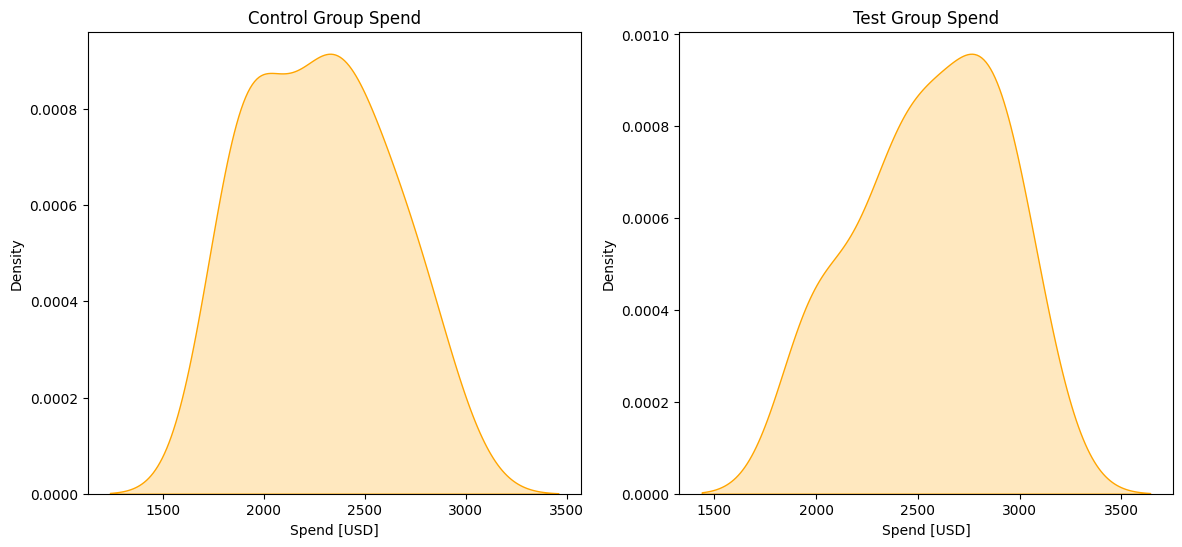

In [56]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))

ax1 = sns.kdeplot(control['Spend [USD]'], ax=ax[0], color='orange', fill=True)
ax2 = sns.kdeplot(test['Spend [USD]'], ax=ax[1], color='orange', fill=True)
ax1.set_title('Control Group Spend')
ax2.set_title('Test Group Spend')

plt.show()

**Impressions**

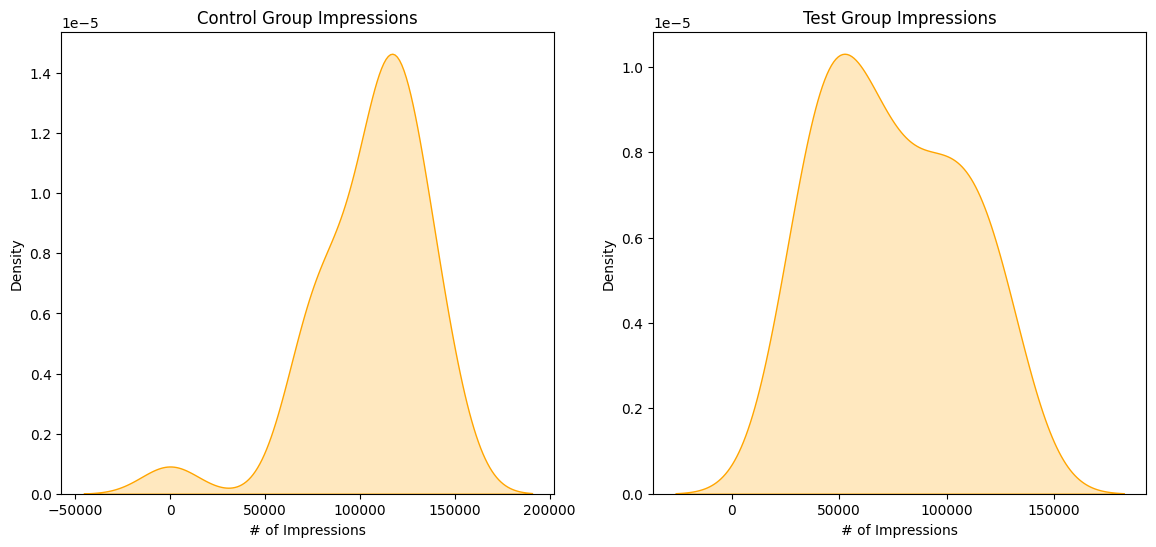

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))

ax1 = sns.kdeplot(control['# of Impressions'], ax=ax[0], color='orange', fill=True)
ax2 = sns.kdeplot(test['# of Impressions'], ax=ax[1], color='orange', fill=True)
ax1.set_title('Control Group Impressions')
ax2.set_title('Test Group Impressions')

plt.show()

**CLicks**

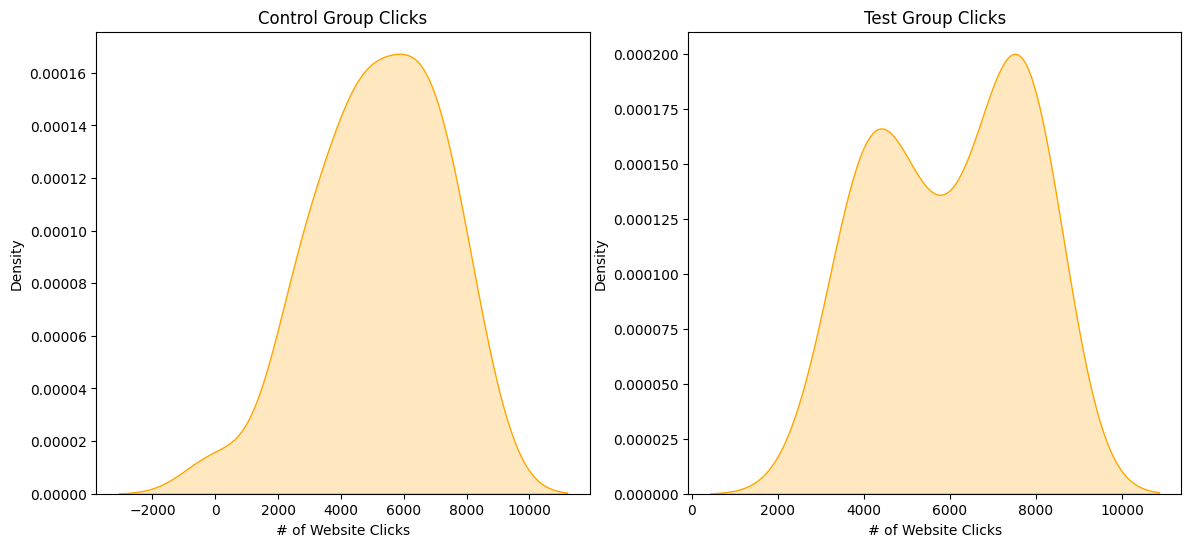

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))

ax1 = sns.kdeplot(control['# of Website Clicks'], ax=ax[0], color='orange', fill=True)
ax2 = sns.kdeplot(test['# of Website Clicks'], ax=ax[1], color='orange', fill=True)
ax1.set_title('Control Group Clicks')
ax2.set_title('Test Group Clicks')

plt.show()

**Purchases**

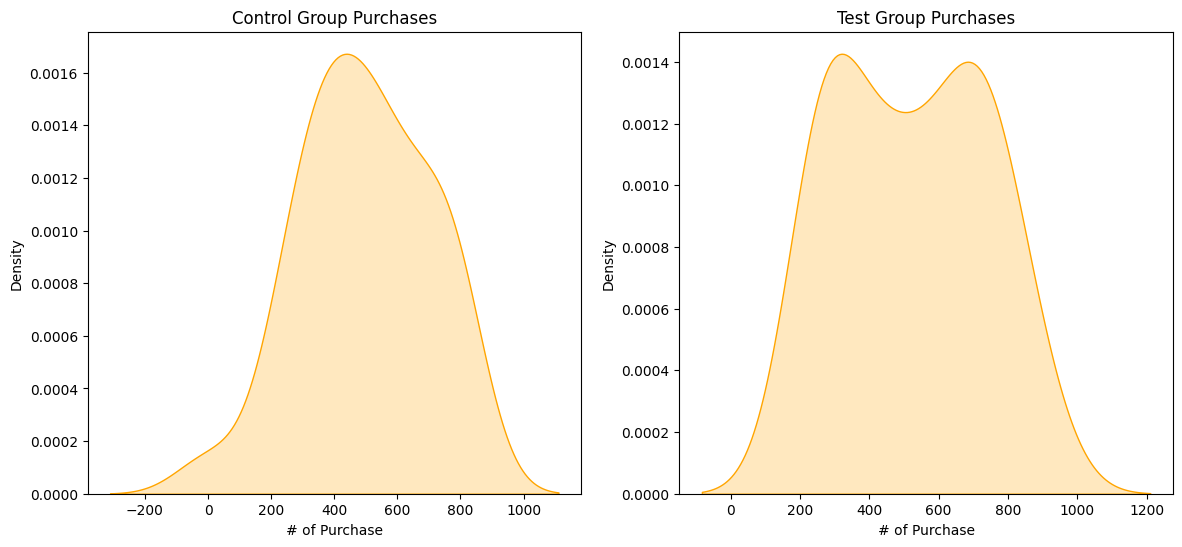

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))

ax1 = sns.kdeplot(control['# of Purchase'], ax=ax[0], color='orange', fill=True)
ax2 = sns.kdeplot(test['# of Purchase'], ax=ax[1], color='orange', fill=True)
ax1.set_title('Control Group Purchases')
ax2.set_title('Test Group Purchases')

plt.show()

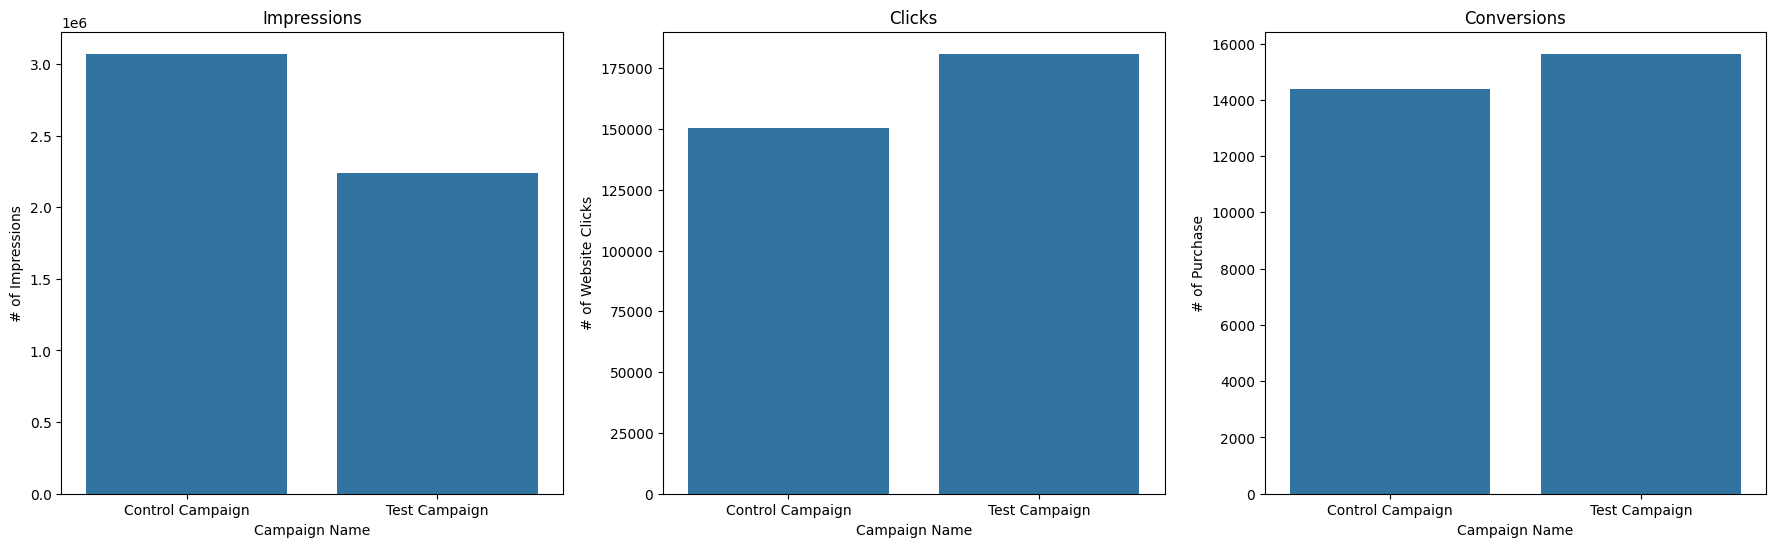

In [60]:
data_all = pd.concat([control, test])
fig, ax = plt.subplots(ncols=3, figsize=(22,6))
ax1 = sns.barplot(data=data_all, x='Campaign Name', y='# of Impressions', errorbar=('ci', False), ax=ax[0], estimator='sum')
ax2 = sns.barplot(data=data_all, x='Campaign Name', y='# of Website Clicks', errorbar=('ci', False), ax=ax[1], estimator='sum')
ax3 = sns.barplot(data=data_all, x='Campaign Name', y='# of Purchase', errorbar=('ci', False), ax=ax[2], estimator='sum')

ax1.set_title('Impressions')
ax2.set_title('Clicks')
ax3.set_title('Conversions')

plt.show()

In [63]:
# Function to calculate confidence interval, where measures A and B are the numerator and denominator for the metric
def ratio_diff_confidence_interval(metric, measure_a, measure_b, alpha):
    p_pool = (control[measure_a].sum() + test[measure_a].sum())/(control[measure_b].sum() + test[measure_b].sum())
    pool_se = np.sqrt(p_pool * (1-p_pool) * (1/control[measure_b].sum() + 1/test[measure_b].sum()))

    metric_diff = (test[measure_a].sum()/test[measure_b].sum()) - (control[measure_a].sum()/control[measure_b].sum())
    margin_of_error = stats.norm.ppf(1-alpha/2) * pool_se

    ci_lower_bound = metric_diff - margin_of_error
    ci_upper_bound = metric_diff + margin_of_error

    print("The difference in {0} between groups is {1}".format(metric, round(metric_diff, 4)))
    print("Confidence Interval: [", round(ci_lower_bound, 4),",",round(ci_upper_bound, 4), "]")
    print()
    if (ci_lower_bound > 0) or (ci_upper_bound < 0):
        print('Reject Null Hypothesis, statistically significant difference between Control and Test {}'.format(metric))
    else:
        print('Unable to reject Null Hypothesis, no statistically significant difference between Control and Test {}'.format(metric))


def cont_diff_confidence_interval(metric, alpha):
    se = np.sqrt((control[metric].std()**2/control[metric].count() + test[metric].std()**2/test[metric].count()))

    metric_diff = test[metric].mean() - control[metric].mean()
    margin_of_error = stats.norm.ppf(1-alpha/2) * se

    ci_lower_bound = metric_diff - margin_of_error
    ci_upper_bound = metric_diff + margin_of_error

    print("The difference in {0} between groups is {1}".format(metric, round(metric_diff, 4)))
    print("Confidence Interval: [", round(ci_lower_bound, 4),",",round(ci_upper_bound, 4), "]")
    print()
    if (ci_lower_bound > 0) or (ci_upper_bound < 0):
        print('Reject Null Hypothesis, statistically significant difference between Control and Test {}'.format(metric))
    else:
        print('Unable to reject Null Hypothesis, no statistically significant difference between Control and Test {}'.format(metric))

ValueError: cannot reindex on an axis with duplicate labels

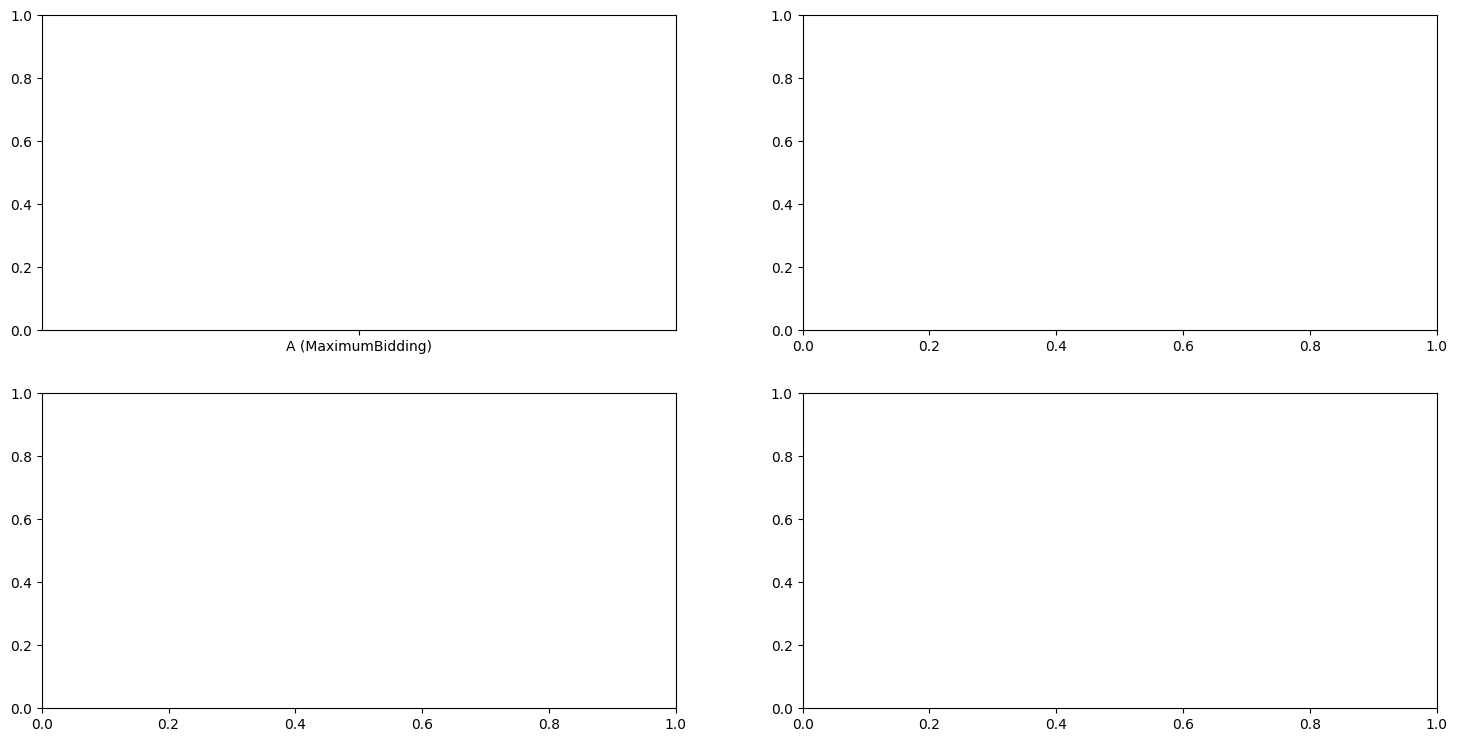

In [72]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

In [64]:
ratio_diff_confidence_interval(metric='CTR',
                    measure_a='# of Website Clicks',
                    measure_b='# of Impressions',
                    alpha=.05)

The difference in CTR between groups is 0.0319
Confidence Interval: [ 0.0315 , 0.0323 ]

Reject Null Hypothesis, statistically significant difference between Control and Test CTR


ValueError: cannot reindex on an axis with duplicate labels

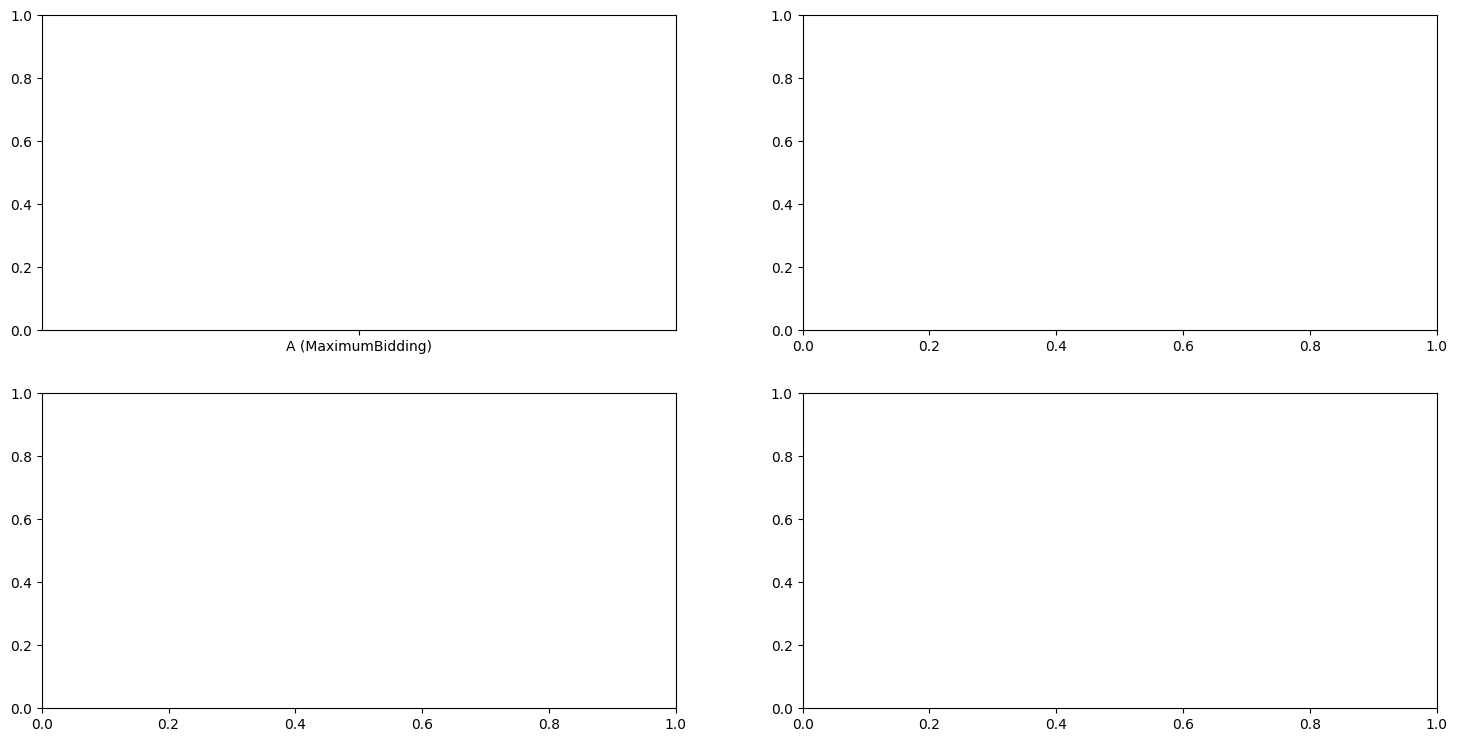

In [69]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [66]:
print(AB.index.duplicated().any())

True


In [67]:
for col in ['Group'] + cols:
         print(f'{col}: {AB[col].duplicated().any()}')

Group: True
Cost per Action: False
Conversion Rate: False
# of Purchase: True


In [70]:
#TODO : create your dataframe for AB test and print the first 3 rows of it.
group_A = AB[AB['Group']=='A (MaximumBidding)'][['# of Purchase','Website Click Through Rate','Cost per Action','Conversion Rate']]
group_B = AB[AB['Group']=='B (AverageBidding)'][['# of Purchase','Website Click Through Rate','Cost per Action','Conversion Rate']]

print(group_A.head(3))
print('*'*30)
print(group_B.head(3))

   # of Purchase  Website Click Through Rate  Cost per Action  Conversion Rate
0            618                    8.483471         0.014865      2186.103193
1            511                    6.700264         0.007404      2925.943280
2            372                    4.941121         0.009199      3913.798402
******************************
   # of Purchase  Website Click Through Rate  Cost per Action  Conversion Rate
0            255                    7.681416         0.035627      2779.163924
1            677                    4.623755         0.012518      4360.339274
2            578                   11.222123         0.018102      1656.943564


## 5. Two Independent Sample T-Test
### 5.1. Assumption Check
#### 5.1.1. Normality Assumption (shapiro test)

 * **H0**: Normal distribution assumption is provided.
 * **H1**: ... not provided.

In [ ]:
#TODO : Aply the normality assumption of the dataframe for A


In [ ]:
#TODO : compute p_value for normality on group A from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Does the HO hypothesis get rejected ? why ?

In [ ]:
#TODO : Aply the normality assumption of the dataframe for B


In [ ]:
#TODO : compute p_value for normality on group B from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Does the HO hypothesis get rejected ? why ?

### 5.1.2. Variance Homogeneity Assumption
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if A and B have equal variances, which is a common assumption for various statistical tests :

In [ ]:
#TODO : Performs the Levene test for equality of variances on two groups, A and B, from the df_AB dataframe

In [ ]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.


Conclude about the variances, are they homogeneous ?

### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [ ]:
# Average Biddingin (Test Group)
stats.mannwhitneyu(df_AB["A"], df_AB["B"])

In [ ]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Should the H0 hypothesis be rejected ? Why ? What can you conclude ?

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**


   
**2. Can we conclude statistically significant results?**

  


**3. Which statistical test did you use, and why?**
   
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**

   